In [1]:
import os
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
DEBUG = False
RUN = 1
LR = 0.000005
FCC_SIZE = 128
NUM_EPOCHS = 150
BATCH_SIZE = 32
MODEL = 'RESNET'

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Load the full train dataset
full_train_dataset = datasets.ImageFolder(root = '/kaggle/input/disaster/train', transform=transform)
val_dataset = datasets.ImageFolder(root = '/kaggle/input/disaster/validation', transform = transform)

# Calculate the sizes for train and test splits
train_size = int(0.75 * len(full_train_dataset))
test_size = len(full_train_dataset) - train_size


    
# Split the dataset
train_dataset, test_dataset = random_split(full_train_dataset, [train_size, test_size])
if (DEBUG == True) :
    reduced_train_size = int(0.1 * len(train_dataset))
    reduced_test_size = int(0.1 * len(test_dataset))
    reduced_val_size = int(0.1 * len(val_dataset))
    train_dataset = Subset(train_dataset, list(range(reduced_train_size)))
    test_dataset = Subset(test_dataset, list(range(reduced_test_size)))
    val_dataset = Subset(val_dataset, list(range(reduced_test_size)))   
    
# Create DataLoaders for both train and test datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size =BATCH_SIZE, shuffle = False)

# Check the sizes of each split
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")
print(f"Val set size: {len(val_loader.dataset)}")


 

Training set size: 1200
Test set size: 400
Val set size: 400


Validation loss improved to 1.4318, saving model...
Epoch [1/150]
Train Loss: 1.3510, Train Acc: 30.42%
Validation Loss: 1.4318, Validation Acc: 25.25%

Train F1 Micro: 0.30416666666666664 Train F1 Macro: 0.2562126210201949
Val F1 Micro: 0.2525 Val F1 Macro: 0.11355300578601549
Validation loss improved to 1.0646, saving model...
Epoch [2/150]
Train Loss: 1.1627, Train Acc: 53.00%
Validation Loss: 1.0646, Validation Acc: 55.25%

Train F1 Micro: 0.53 Train F1 Macro: 0.515207185585645
Val F1 Micro: 0.5525 Val F1 Macro: 0.5180846225404727
Validation loss improved to 0.9895, saving model...
Epoch [3/150]
Train Loss: 1.0395, Train Acc: 59.17%
Validation Loss: 0.9895, Validation Acc: 61.00%

Train F1 Micro: 0.5916666666666667 Train F1 Macro: 0.5901646215896998
Val F1 Micro: 0.61 Val F1 Macro: 0.5987776826932697
Validation loss improved to 0.8946, saving model...
Epoch [4/150]
Train Loss: 0.9449, Train Acc: 64.25%
Validation Loss: 0.8946, Validation Acc: 69.75%

Train F1 Micro: 0.6425 Train F1

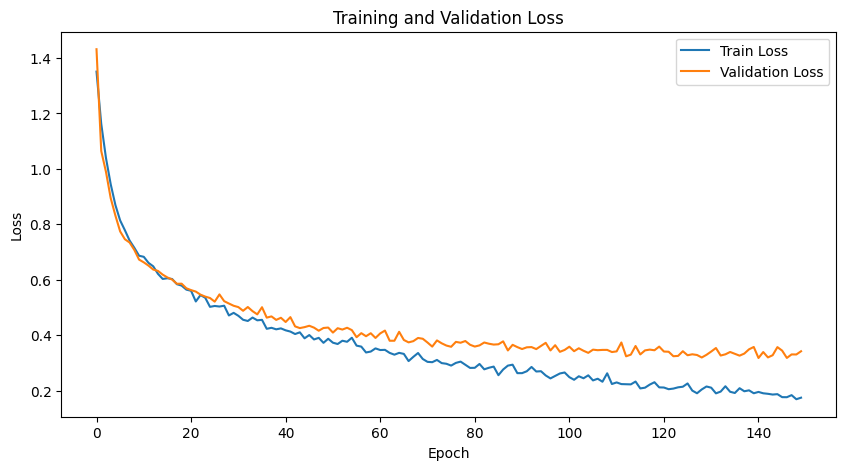

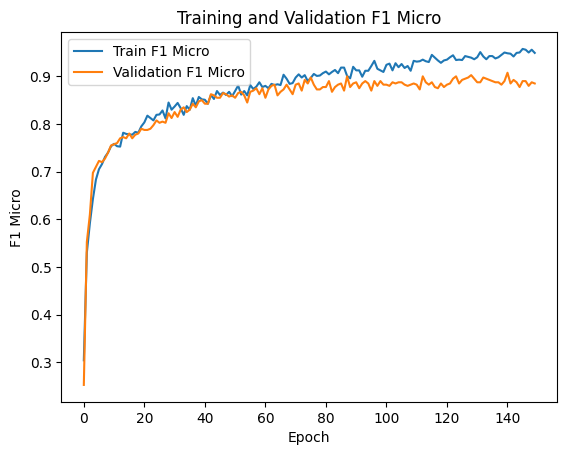

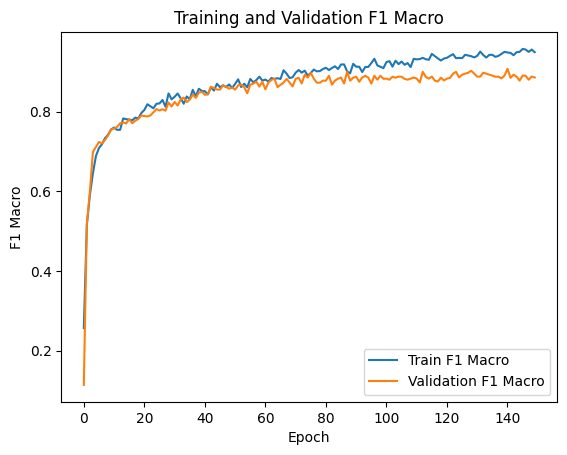

In [4]:
if MODEL != 'SVM':
    output_folder = '/kaggle/working/'
    os.makedirs(output_folder, exist_ok=True) 
    
    prev_val_loss = 1e8
    eipselon = 1e-3
    num_epochs = NUM_EPOCHS
    best_val_loss = float('inf')
    
    val_loss_array = []
    train_loss_array = []
    train_f1_micro_array = []
    train_f1_macro_array = []
    val_f1_micro_array = []
    val_f1_macro_array = []
    
    # Define a simple CNN model
    class DisasterCNN(nn.Module):
        def __init__(self, num_classes=4):
            super(DisasterCNN, self).__init__()
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
            self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            self.fc1 = nn.Linear(128 * 28 * 28, FCC_SIZE)
            self.fc2 = nn.Linear(FCC_SIZE, num_classes)
            self.dropout = nn.Dropout(0.5)
    
        def forward(self, x):
            x = self.pool(torch.relu(self.conv1(x)))
            x = self.pool(torch.relu(self.conv2(x)))
            x = self.pool(torch.relu(self.conv3(x)))
            x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
            x = torch.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x
    
    
    class resNetBlock(nn.Module):
        def __init__(self, in_channels, out_channels, normalize):
            super(resNetBlock, self).__init__()
            stride = 1 if in_channels == out_channels else 2
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, stride = stride, padding = 1),
                normalize(out_channels),
                nn.ReLU()
            )
            self.conv2 = nn.Sequential(
                nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, stride = 1, padding = 1),
                normalize(out_channels)
            )
            self.downsample = nn.Sequential()
            if stride == 2:
                self.downsample = nn.Sequential(
                    nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, stride = stride, padding = 0),
                    normalize(out_channels),
                )
        
        def forward(self, x):
            out = self.conv1(x)
            out = self.conv2(out)
            identity = self.downsample(x)
            out += identity
            out = nn.ReLU()(out)
            return out
        
    class resNet(nn.Module):
        def __init__(self, layers_cnt, num_classes, normalize):
            super(resNet, self).__init__()
            self.n = layers_cnt
            self.block = resNetBlock
            self.normalize = normalize
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 1),
                self.normalize(16),
                nn.ReLU()
            )
            self.layer1 = self.make_layer(16, 16)
            self.layer2 = self.make_layer(16, 32)
            self.layer3 = self.make_layer(32, FCC_SIZE)
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(FCC_SIZE, num_classes)
        
        def make_layer(self, in_channels, out_channels):
            layers = []
            layers.append(self.block(in_channels, out_channels, self.normalize))
            for i in range(self.n - 1):
                layers.append(self.block(out_channels, out_channels, self.normalize))
            return nn.Sequential(*layers)
    
        def forward(self, x):
            x = self.conv1(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
            return x  
    
    
    # Initialize the model, criterion, and optimizer
    if MODEL == 'RESNET': model = resNet(4, 4, nn.BatchNorm2d).to(device)
    else: model = DisasterCNN(4).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    # Training function
    def train_model(model, dataloader, criterion, optimizer):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_outputs = []
        all_labels = []
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
    
            # Zero the parameter gradients
            optimizer.zero_grad()
    
            # Forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            # Track accuracy and loss
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            _, preds = torch.max(outputs, 1)
            all_outputs.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

        resnet_f1_micro = f1_score(all_labels, all_outputs, average='micro')
        resnet_f1_macro = f1_score(all_labels, all_outputs, average='macro')
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc, resnet_f1_micro, resnet_f1_macro
    
    # Validation function
    def validate_model(model, dataloader, criterion):
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_outputs = []
        all_labels = []
        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(device), labels.to(device)
    
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
    
                # Track accuracy and loss
                running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                _, preds = torch.max(outputs, 1)
                all_outputs.extend(preds.detach().cpu().numpy())
                all_labels.extend(labels.detach().cpu().numpy())
                    
        resnet_f1_micro = f1_score(all_labels, all_outputs, average='micro')
        resnet_f1_macro = f1_score(all_labels, all_outputs, average='macro')
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc, resnet_f1_micro, resnet_f1_macro
    
    # Training loop
    
    for epoch in range(num_epochs):
        train_loss, train_acc, train_f1_micro, train_f1_macro = train_model(model, train_loader, criterion, optimizer)
        val_loss, val_acc, val_f1_micro, val_f1_macro = validate_model(model, val_loader, criterion)
        
        val_loss_array.append(val_loss)
        train_loss_array.append(train_loss)
        train_f1_micro_array.append(train_f1_micro)
        train_f1_macro_array.append(train_f1_macro)
        val_f1_micro_array.append(val_f1_micro)
        val_f1_macro_array.append(val_f1_macro)
        prev_val_loss = val_loss
        
        # Check if validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Save the model with the best validation loss
            best_model_path = os.path.join(output_folder, f'disaster_classification_model{RUN}.pth')
            torch.save(model.state_dict(), best_model_path)
            print(f"Validation loss improved to {val_loss:.4f}, saving model...")
    
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%\n")
        print("Train F1 Micro:", train_f1_micro, "Train F1 Macro:", train_f1_macro)
        print("Val F1 Micro:", val_f1_micro, "Val F1 Macro:", val_f1_macro)
    
    # Testing the model on the test set
    test_loss, test_acc, test_f1_micro, test_f1_macro = validate_model(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print("Test F1 Micro:", test_f1_micro, "Test F1 Macro:", test_f1_macro)
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_array, label='Train Loss')
    plt.plot(val_loss_array, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Save the plot
    plot_path = os.path.join(output_folder, f'training_validation_loss{RUN}.png')
    plt.savefig(plot_path)
    plt.show()

    plt.clf()
    plt.plot(train_f1_micro_array, label='Train F1 Micro')
    plt.plot(val_f1_micro_array, label='Validation F1 Micro')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Micro')
    plt.title('Training and Validation F1 Micro')
    plt.legend()
    
    # Save the plot
    plot_path = os.path.join(output_folder, f'f1_micro{RUN}.png')
    plt.savefig(plot_path)
    plt.show()

    plt.clf()
    plt.plot(train_f1_macro_array, label='Train F1 Macro')
    plt.plot(val_f1_macro_array, label='Validation F1 Macro')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Macro')
    plt.title('Training and Validation F1 Macro')
    plt.legend()
    
    # Save the plot
    plot_path = os.path.join(output_folder, f'f1_macro{RUN}.png')
    plt.savefig(plot_path)
    plt.show()
    
